**Implementing D-MAB, as described in DaCosta et al. - 2008 - Adaptive operator selection with dynamic multi-arm**

>  (hybrid between UCB1 and Page-Hinkley (PH) test)

D-MAB maintains four indicators for each arm $i$:
1. number $n_{i, t}$ of times $i$-th arm has been played up to time $t$;
2. the average empirical reward $\widehat{p}_{j, t}$ at time $t$;
3. the average and maximum deviation $m_i$ and $M_i$ involved in the PH test, initialized to $0$ and updated as detailed below. At each time step $t$:

D-MAB selects the arm $i$ that maximizes equation 1:

$$\widehat{p}_{i, t} + \sqrt{\frac{2 \log \sum_{k}n_{k, t}}{n_{i, t}}}$$

> Notice that the sum of the number of times each arm was pulled is equal to the time $\sum_{k}n_{k, t} = t$, but since their algorithm resets the number of picks, we need to go with the summation. 

and receives some reward $r_t$, drawn after reward distribution $p_{i, t}$.

> I think there is a typo in the eq. 1 on the paper. I replaced $j$ with $i$ in the lower indexes.

The four indicators are updated accordingly:

- $\widehat{p}_{i, t} :=\frac{1}{n_{i, t} + 1}(n_{i, t}\widehat{p}_{i, t} + r_t)$
- $n_{i, t} := n_{i, t}+1$
- $m_i := m_i + (\widehat{p}_{i, t} - r_t + \delta)$
- $M_i:= \text{max}(M_i, m_i)$

And if the PH test is triggered ($M_i - m_i > \lambda$), the bandit is restarted, i.e., for all arms, all indicators are set to zero (the authors argue that, empirically, resetting the values is more robust than decreasing them with some mechanism such as probability matching).

> I will reset to 1 instead of 0 (as the original paper does) to avoid divide by zero when calculating UCB1.

The PH test is a standard test for the change hypothesis. It works by monitoring the difference between $M_i$ and $m_i$, and when the difference is greater than some uuser-specified threshold $\lambda$, the PH test is triggered, i.e., it is considered that the Change hypothesis holds.

Parameter $\lambda$ controls the trade-off between false alarms and un-noticed changes. Parameter $\delta$ enforces the robustness of the test when dealing with slowly varying environments.

We also need a scaling mechanism to control the Exploration _versus_ Exploitation balance. They proposed two, from which I will focus on the first: Multiplicative Scaling (cUCB). **It consists on multiplying all rewards by a fixed user-defined parameter $C_{M-\text{scale}}$.

This way, we need to give to our D-MAB 3 parameters: $\lambda$, $\delta$, and $C_{M - \text{scale}}$. In the paper they did a sensitivity analysis of the parameters, but I think they should be fine tuned for each specific data set.

> Brush originally sample the mutations using an uniform distribution. This algorithm chooses the arms using an deterministic approach --- the one that maximizes the UCB1 score. Somehow we need to convert them to have a transparent implementation to the user.

In [1]:
import numpy as np

class D_MAB:
    def __init__(self, num_bandits, delta=0.15, lmbda=0.25):
        self.num_bandits = num_bandits

        # Store tuples when update is called. Tuples will have 3 values:
        # (time instant t, arm idx, reward)
        self.pull_history  = []
        self.reset_history = []

        # This is the probability that should be used to update brush probs
        self._probabilities = np.ones(num_bandits)/num_bandits

        self.delta = delta # how to define these values???
        self.lmbda = lmbda

        self._reset_indicators() # Creating the indicators 

    def _reset_indicators(self):
        self._avg_rewards    = np.zeros(self.num_bandits)
        self._num_pulls      = np.zeros(self.num_bandits)
        self._avg_deviations = np.zeros(self.num_bandits)
        self._max_deviations = np.zeros(self.num_bandits)

    @property
    def probabilities(self):
        # How to transform our UCB1 scores into node probabilities?
        return self._probabilities
    
    @probabilities.setter
    def probabilities(self, new_probabilities):
        if len(self._probabilities)==len(new_probabilities):
            self._probabilities = new_probabilities
        else:
            print(f"New probabilities must have size {self.num_bandits}")

    def choose_arm(self):
        """Uses previous recordings of rewards to pick the arm that maximizes
        the UCB1 function. The choice is made in a deterministic way.
        """

        # We need that the reward is in [0, 1] (not avg_reward, as it seems to
        # render worse results). It looks like normalizing the rewards is a
        # problem: reward should be [0, 1], but not necessarely avg_rewards too
        rs = self._avg_rewards
        ns = self._num_pulls
        
        UCB1s = rs + np.sqrt(2*np.log1p(sum(ns))/(ns+1))

        return np.nanargmax(UCB1s)

    def update(self, arm_idx, reward):
        # Here we expect that the reward was already scaled to be in the 
        # interval [0, 1] (in the original paper, they sugest using a scaling
        # factor as an hyperparameter).

        self.pull_history.append( (len(self.pull_history), arm_idx, reward) )

        if np.isfinite(reward):
            self._avg_rewards[arm_idx]    = \
                (self._num_pulls[arm_idx]*self._avg_rewards[arm_idx] + reward)/(self._num_pulls[arm_idx]+1)
            self._avg_deviations[arm_idx] = \
                self._avg_deviations[arm_idx] + (self._avg_rewards[arm_idx] - reward + self.delta)
            
        self._num_pulls[arm_idx]    = self._num_pulls[arm_idx] +1
        self._max_deviations[arm_idx] = \
            np.maximum(self._max_deviations[arm_idx], self._avg_deviations[arm_idx])

        if (self._max_deviations[arm_idx] - self._avg_deviations[arm_idx] > self.lmbda):
            self._reset_indicators()
            self.reset_history.append(len(self.pull_history))

        return self

Below I'll create a simple bandit configuration so we can do a sanity check of our `D_MAB` implementation.

In [2]:
# Sanity checks

class Bandits:
    def __init__(self, reward_prob):
        # Implementing simple bandits.
        self.reward_prob = reward_prob # True reward prob., which learner shoudn't know
        self.n_bandits   = len(reward_prob) 

    def pull(self, arm_idx):
        # Sampling over a normal distr. with mu=0 and var=1
        result = np.random.randn()
        
        # return a positive or nullary reward (Bernoulli random variable).
        return 1.0 if result > self.reward_prob[arm_idx] else 0.0

for probs, descr, expec in [
    (np.array([ 1.0,  1.0, 1.0,  1.0]), 'All bandits with same probs'  , 'similar amount of pulls for each arm'         ),
    (np.array([-1.0,  0.2, 0.0,  1.0]), 'One bandit with higher prob'  , 'more pulls for first arm, less pulls for last'),
    (np.array([-0.2, -1.0, 0.0, -1.0]), 'Two bandits with higher probs', '2nd approx 4th > 1st > 3rd'                   ),
]:
    bandits = Bandits(probs)

    print("------------------------ optimizing ------------------------")

    learner = D_MAB(4)
    for i in range(1000):
        arm_idx = learner.choose_arm()
        reward  = bandits.pull(arm_idx)

        learner.update(arm_idx, reward) 

    total_rewards = {arm_idx : sum([r for (t, i, r) in learner.pull_history if i==arm_idx])
                     for arm_idx in range(learner.num_bandits)}

    total_pulls   = {arm_idx : sum([1 for (t, i, r) in learner.pull_history if i==arm_idx])
                     for arm_idx in range(learner.num_bandits)}

    print("cum. reward for each arm    : ", total_rewards)
    print("number of pulls for each arm: ", total_pulls)
    print(f"(it was expected: {expec})")

------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 44.0, 1: 41.0, 2: 28.0, 3: 48.0}
number of pulls for each arm:  {0: 273, 1: 257, 2: 230, 3: 240}
(it was expected: similar amount of pulls for each arm)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 462.0, 1: 78.0, 2: 79.0, 3: 19.0}
number of pulls for each arm:  {0: 542, 1: 178, 2: 175, 3: 105}
(it was expected: more pulls for first arm, less pulls for last)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 107.0, 1: 235.0, 2: 89.0, 3: 321.0}
number of pulls for each arm:  {0: 177, 1: 292, 2: 163, 3: 368}
(it was expected: 2nd approx 4th > 1st > 3rd)


Ok, so the D-MAB seems to work. Now let's add this MAB inside mutation to update PARAMS option and control dinamically the mutaiton probabilities during evolution.

We can import the brush estimator and replace the `_mutation` by a custom function. Ideally, to use this python MAB optimizer, we need to have an object created to keep track of the variables, and the object needs to wrap the _pull_ action, as well as evaluating the reward based on the result.

> we'll need to do a _gambiarra_ to know which mutation is used so we can correctly update `D_MAB`. All MAB logic is implemented in python, and we chose the mutation in python as well. To make sure a specific mutation was used, we force it to happen by setting others' weights to zero. this way we know exactly what happened in the C++ code

In [3]:
from brush.estimator import BrushEstimator
from sklearn.base import ClassifierMixin, RegressorMixin
from deap import creator
import _brush
from deap_api import nsga2 

class BrushEstimatorMod(BrushEstimator): # Modifying brush estimator
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _mutate(self, ind1):
        # Overriding the mutation so it updates our sampling method. Doing the
        # logic on the python-side for now.

        # Creating a wrapper for mutation to be able to control what is happening
        # in the C++ code (this should be prettier in a future implementation)
        mutations = ['point', 'insert', 'delete', 'toggle_weight']
        params = self.get_params()
        
        ignore_this_time = True if (ind1.prg.size()+1>=self.max_size
                                    or ind1.prg.depth()+1>=self.max_depth) else False

        # Insert Mutation will not work, even if we force it, when the expression
        # is already at maximum size.
        # In this case, we'll do the mutation without controlling the probabilities.
        if ignore_this_time:
            for i, m in enumerate(mutations):
                params['mutation_options'][m] = 0.25 # let cpp do the mutation 
        else:
            mutation_idx = self.learner_.choose_arm()

            for i, m in enumerate(mutations):
                params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        _brush.set_params(params)
    
        # ind1.prg.mutate is a convenient interface that uses the current search 
        # space to sample mutations
        offspring = creator.Individual(ind1.prg.mutate())

        offspring.fitness.values = self.toolbox_.evaluate(offspring)
        
        # We compare fitnesses using the deap overloaded operators
        # from the docs: When comparing fitness values that are **minimized**,
        # ``a > b`` will return :data:`True` if *a* is **smaller** than *b*.
        # (this means that this comparison should work agnostic of min/max problems,
        # or even a single-objective or multi-objective problem)
        reward = 1.0 if offspring.fitness > ind1.fitness else 0.0
        
        if not ignore_this_time:
            self.learner_.update(mutation_idx, reward)
        
        return offspring
    
    def fit(self, X, y):

        _brush.set_params(self.get_params())

        self.data_ = self._make_data(X,y)
        # self.data_.print()

        # set n classes if relevant
        if self.mode=="classification":
            self.n_classes_ = len(np.unique(y))

        # We have 4 different mutations, and the learner will learn to choose
        # between these options by maximizing the reward when using each one
        self.learner_ = D_MAB(4)

        if isinstance(self.functions, list):
            self.functions_ = {k:1.0 for k in self.functions}
        else:
            self.functions_ = self.functions

        self.search_space_ = _brush.SearchSpace(self.data_, self.functions_)

        self.toolbox_ = self._setup_toolbox(data=self.data_)

        archive, logbook = nsga2(
            self.toolbox_, self.max_gen, self.pop_size, 0.9, self.verbosity)

        self.archive_ = archive
        self.best_estimator_ = self.archive_[0].prg

        return self
    

class BrushClassifierMod(BrushEstimatorMod,ClassifierMixin):
    def __init__( self, **kwargs):
        super().__init__(mode='classification',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.abs(data.y-ind.prg.predict(data)).sum(), 
            ind.prg.size()
        )
    
    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_classifier(self.max_depth, self.max_size)
            if self.n_classes_ == 2 else
            self.search_space_.make_multiclass_classifier(self.max_depth, self.max_size)
            )

    def predict_proba(self, X):
        data = self._make_data(X)
        return self.best_estimator_.predict_proba(data)


class BrushRegressorMod(BrushEstimatorMod, RegressorMixin):
    def __init__(self, **kwargs):
        super().__init__(mode='regressor',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.sum((data.y- ind.prg.predict(data))**2),
            ind.prg.size()
        )

    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_regressor(self.max_depth, self.max_size)
        )

## Regression problem

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gen	evals	ave            	std                    	min      
0  	200  	[   nan 20.925]	[       nan 0.97435876]	[nan 20.]
1  	200  	[   nan 16.925]	[       nan 4.98491474]	[nan  1.]
2  	200  	[   nan 10.495]	[      nan 5.4488508]  	[nan  1.]
3  	200  	[ nan 4.73]    	[       nan 2.58400851]	[nan  1.]
4  	200  	[  nan 2.425]  	[       nan 1.16377618]	[nan  1.]
5  	200  	[  nan 1.725]  	[       nan 0.69955343]	[nan  1.]
6  	200  	[ nan 1.43]    	[       nan 0.62056426]	[nan  1.]
7  	200  	[5.15006834 1.05      ]	[1.27027425 0.21794495]	[2.73836088 1.        ]
8  	200  	[4.4173494 1.025    ]  	[1.03668311 0.15612495]	[2.73836088 1.        ]
9  	200  	[3.86163747 1.01      ]	[0.11289354 0.09949874]	[2.73836088 1.        ]
10 	200  	[3.86163747 1.01      ]	[0.11289354 0.09949874]	[2.73836088 1.        ]
11 	200  	[3.86163747 1.01      ]	[0.11289354 0.09949874]	[2.73836088 1.        ]

Brush version  Original                                    Modified   
metric            score                        best model     score   
run 0          0.292958              1.00*Square(0.96*x1)  0.363372  \
run 1          0.363372         If(x1>0.91,1.61,-0.52*x1)  0.350809   
run 2          0.314972                0.51*Acos(1.10*x2)  0.835548   
run 3          0.363372      If(x1>0.91,5.00*x2,-0.52*x1)  0.292958   
run 4          0.292958                   Square(0.96*x1)  1.000000   
run 5          0.325058                      Cos(1.72*x2)  0.350809   
run 6          0.326358                 1.04*Cos(1.73*x2)  0.490733   
run 7          0.325058                      Cos(1.72*x2)  0.508543   
run 8          0.198205                      Abs(0.74*x1)  0.292958   
run 9          0.363372      If(x1>0.91,1.70*x1,-0.52*x1)  0.326358   
run 10         0.397507             Square(Sin(-4.25*x2))  0.350809   
run 11         0.325058                      Cos(1.72*x2)  0.363372   
run 12         0.425247  Logistic(50.64*Logabs(-1.15*x1))  0.326358   
run 13         0.325058                      Cos(1.72*x2)  0.624433   
run 14         0.397507              Square(Sin(4.25*x2))  0.350809   
run 15         0.363372      If(x1>0.91,5.00*x2,-0.52*x1)  0.308425   
run 16         0.324176                0.05*Cosh(3.63*x1)  1.000000   
run 17         0.397507             Square(Sin(-4.25*x2))  0.508543   
run 18         0.292958                   Square(0.96*x1)  0.999129   
run 19         0.397507             Square(Sin(-4.25*x2))  0.508543   
run 20         0.292958                   Square(0.96*x1)  0.326358   
run 21         0.363372      If(x1>0.91,5.00*x2,-0.52*x1)  0.350809   
run 22         0.363372      If(x1>0.91,5.00*x2,-0.52*x1)  0.363372   
run 23         0.304625                0.06*Cosh(3.34*x1)  0.490733   
run 24         0.326358                 1.04*Cos(1.73*x2)  0.649267   
run 25         0.275650                   Logabs(2.31*x1)  0.326358   
run 26         0.325058                      Cos(1.72*x2)  0.508543   
run 27         0.326358                 1.04*Cos(1.73*x2)  0.350809   
run 28         0.397507              Square(Sin(4.25*x2))  0.573936   
run 29         0.292958                   Square(0.96*x1)  0.326358   

Brush version                                                      
metric                                                best model   
run 0                                  If(x1>0.91,1.61,-0.52*x1)  \
run 1                                      If(x1>0.91,1.61,0.38)   
run 2          Mean(If(x1>0.91,9.83,1.69),-1.75*x2,-2.39*x1,-...   
run 3                                            0.91*Square(x1)   
run 4                          Square(Median(-2.00*x1,-2.00*x2))   
run 5                                      If(x1>0.91,1.61,0.38)   
run 6                          Square(If(x1>0.91,1.27,-0.85*x1))   
run 7                         Median(2.01,-1.94*x2,1.27*x1,1.27)   
run 8                                      0.96*Square(-0.98*x1)   
run 9                                          1.04*Cos(1.73*x2)   
run 10                                     If(x1>0.91,1.61,0.38)   
run 11                                 If(x1>0.91,1.61,-0.52*x1)   
run 12                                         1.04*Cos(1.73*x2)   
run 13                       Add(If(x1>0.91,1.82,0.65),-0.67*x2)   
run 14                                     If(x1>0.91,1.61,0.38)   
run 15                        Sum(0.79,0.02*x1,-0.69*x2,0.02*x1)   
run 16         1.22*Square(Mean(1.19*x1,3.62*x2,1.21*x1,1.21*...   
run 17                        Median(2.01,-1.94*x2,1.27,1.27*x1)   
run 18               2.04*Cos(Sum(0.43*x2,-0.31*x2,-1.08*x1,x2))   
run 19                        Median(2.01,1.27*x1,-1.94*x2,1.27)   
run 20                                         1.04*Cos(1.73*x2)   
run 21                                     If(x1>0.91,1.61,0.38)   
run 22                                 If(x1>0.91,1.61,-0.52*x1)   
run 23                     

Brush version   Original   Modified                        
metric             score      score point mutation calls   
count          30.000000  30.000000              30.0000  \
mean            0.335993   0.480635            1693.6000   
std             0.047602   0.216310             239.3335   
min             0.198205   0.292958            1142.0000   
25%             0.307212   0.332471            1559.0000   
50%             0.325708   0.363372            1676.5000   
75%             0.363372   0.508543            1868.2500   
max             0.425247   1.000000            2164.0000   

Brush version                                               
metric        insert mutation calls delete mutation calls   
count                     30.000000             30.000000  \
mean                    2598.500000           1668.933333   
std                      306.768221            251.219774   
min                     2011.000000           1030.000000   
25%                     2398.250000           1565.000000   
50%                     2585.500000           1764.500000   
75%                     2801.250000           1841.250000   
max                     3363.000000           2055.000000   

Brush version                               
metric        toggle_weight mutation calls  
count                            30.000000  
mean                           1676.633333  
std                             242.443663  
min                            1300.000000  
25%                            1499.000000  
50%                            1646.000000  
75%                            1827.750000  
max                            2217.000000

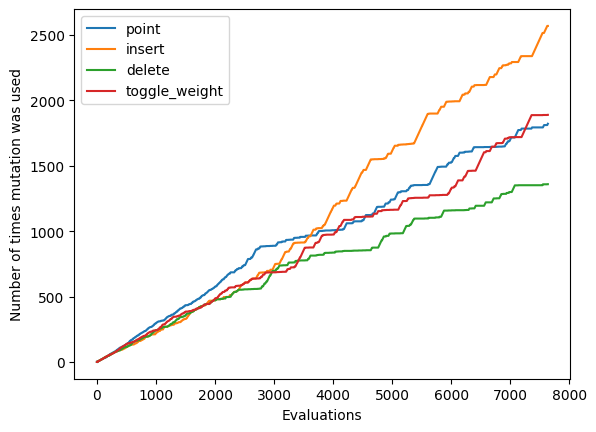

In [4]:
# This is needed to avoid racing conditions (https://deap.readthedocs.io/en/master/tutorials/basic/part4.html)
if __name__ == '__main__':
    import pandas as pd
    from brush import BrushRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    # data = pd.read_csv('../../docs/examples/datasets/d_enc.csv')
    # X = data.drop(columns='label')
    # y = data['label']

    # data = pd.read_csv('../../docs/examples/datasets/d_2x1_subtract_3x2.csv')
    # X = data.drop(columns='target')
    # y = data['target']

    data = pd.read_csv('../../docs/examples/datasets/d_square_x1_plus_2_x1_x2_plus_square_x2.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'pop_size'  : 200,
        'max_gen'   : 40,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')
            kwargs['verbosity'] = (i==29) #verbosity only on last one

            est     = BrushRegressor(**kwargs).fit(X,y)
            est_mab = BrushRegressorMod(**kwargs).fit(X,y)

            total_rewards = {arm_idx : sum([r for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            total_pulls   = {arm_idx : sum([1 for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            
            df.loc[f'run {i}'] = [est.score(X,y), est.best_estimator_.get_model(),
                                est_mab.score(X,y), est_mab.best_estimator_.get_model(), *total_pulls.values()]
        except Exception as e:
            print(e)

    display(df)
    display(df.describe())

    if True: # plot the cumulative history of pulls
        !pip install matplotlib > /dev/null
        import matplotlib.pyplot as plt

        # Plot for evaluations, not generations
        data = np.zeros( (len(est_mab.learner_.pull_history)+1, 4) )
        for i, (t, arm, r) in enumerate(est_mab.learner_.pull_history):
            data[i+1, :] = data[i]
            data[i+1, arm] += 1
            
        plt.plot(data, label=['point', 'insert', 'delete', 'toggle_weight'])
        plt.xlabel("Evaluations")
        plt.ylabel("Number of times mutation was used")

        for x in est_mab.learner_.reset_history:
            plt.axvline(x=x, color='k')
            
        plt.legend()

## Classification problem

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gen	evals	ave            	std                    	min      
0  	200  	[25.075 20.825]	[1.23667902 0.9188988 ]	[20. 20.]
1  	200  	[24.72  13.995]	[1.24161186 6.44243549]	[18.  2.]
2  	200  	[24.34  5.71]  	[1.78728845 5.45306336]	[16.  1.]
3  	200  	[24.37   1.995]	[2.01571327 1.34349358]	[16.  1.]
4  	200  	[22.695  1.57 ]	[3.33945729 1.79027931]	[15.  1.]
5  	200  	[20.4    1.325]	[3.4278273  1.63687965]	[15.  1.]
6  	200  	[18.27  1.31]  	[1.68733518 1.49796529]	[14.  1.]
7  	200  	[17.94  1.15]  	[0.4431704  1.16081868]	[14.  1.]
8  	200  	[17.94  1.15]  	[0.4431704  1.16081868]	[14.  1.]
9  	200  	[17.94  1.15]  	[0.4431704  1.16081868]	[14.  1.]
10 	200  	[17.94  1.15]  	[0.4431704  1.16081868]	[14.  1.]
11 	200  	[17.94  1.15]  	[0.4431704  1.16081868]	[14.  1.]
12 	200  	[17.94  1.15]  	[0.4431704  1.16081868]	[14.  1.]
13 	200  	[17.94  1.15]  	[0.4431704  1.16081868]

Brush version Original                                                      
metric           score                                         best model   
run 0             0.76  Sub(Max(0.03*AIDS,0.57*AIDS,0.28*AIDS),Abs(0.0...  \
run 1             0.72  Logistic(Cos(Sum(0.00*AIDS,1.00*AIDS,1.00*Tota...   
run 2             0.80  Logistic(Tan(Abs(Max(1.01*AIDS,Max(0.64*AIDS,I...   
run 3             0.78  Sinh(Mean(Max(Atan(1.00*Total),1.00,Add(0.31*A...   
run 4             0.82  Median(Median(-0.00*Total,Log(0.00*AIDS),4.19,...   
run 5             0.86  Median(Min(Cos(Prod(Logabs(0.70*AIDS),Sum(1.00...   
run 6             0.86  Mean(Sin(Sum(-2.88,Total,Abs(Log1p(Mean(1659.0...   
run 7             0.78  Logistic(Cos(Sum(1.39,Sqrtabs(Sum(1.00*Total,-...   
run 8             0.68                          Mean(0.00*AIDS,0.69,0.50)   
run 9             0.86  Max(Atan(0.00*AIDS),Sqrt(Sin(Sum(Sqrtabs(1.00*...   
run 10            0.84  Mean(Max(0.00*AIDS,Min(Total,Total,Cos(Max(Sum...   
run 11            0.84  Log1p(Median(Tan(1.00*AIDS),-0.00*AIDS,Ceil(0....   
run 12            0.74  Logistic(Cos(Mean(Tan(1.42),Sqrtabs(Add(Mean(0...   
run 13            0.68  Logistic(0.00*Median(Mean(-1313.13,-1082.38*AI...   
run 14            0.70  Median(Mean(0.00*AIDS,-1.00*Total,2.57),0.33*T...   
run 15            0.72  Sin(Log(Add(-1207.99,Mean(0.07*AIDS,Abs(0.54),...   
run 16            0.68                             Median(0.00*AIDS,0.79)   
run 17            0.68               Logistic(Mean(-1.81,0.06,0.00*AIDS))   
run 18            0.80  Logistic(Tan(Cos(Sum(Prod(Log(Tanh(0.01*AIDS))...   
run 19            0.86  Logistic(Sqrt(Atan(Sin(Max(Mean(0.64*AIDS,Sum(...   
run 20            0.68                    Mean(1.19,-0.50*AIDS,0.50*AIDS)   
run 21            0.80  Logistic(Sin(Median(1.00,Mean(Prod(Tanh(Add(AI...   
run 22            0.80  Sqrtabs(Sin(Log1p(Min(Sum(Abs(0.16*AIDS),-0.00...   
run 23            0.78  Logistic(Log(Sum(Ceil(1.00),Cos(Mean(Sqrtabs(M...   
run 24            0.78  Logistic(Prod(1.00,Sin(Min(1.00,1.00,Sub(Log(S...   
run 25            0.80  Min(Median(Tan(0.62*Total),If(AIDS>68817.00,0....   
run 26            0.82  Mean(Sum(Tan(Add(-269.50*AIDS,0.00*Total)),-0....   
run 27            0.70  Cos(If(AIDS>68817.00,AIDS,Sum(Mean(1.00*Total,...   
run 28            0.78  Add(Median(Ceil(0.00*AIDS),-0.00*AIDS,0.01*AID...   
run 29            0.72  Logistic(Sin(Median(Mean(If(AIDS>68817.00,-0.0...   

Brush version Modified                                                      
metric           score                                         best model   
run 0             0.76  Logistic(Sin(Mean(1.00*AIDS,Max(Mean(1.00*Tota...  \
run 1             0.76  Logistic(Cos(Sqrtabs(Mean(Cos(0.92*AIDS),1.15*...   
run 2             0.78  Div(Mean(1.00*Sum(Median(1.00,3.41*Total,3961....   
run 3             0.82  Atan(Median(Asin(0.99*Sin(Mean(0.00*AIDS,1.00*...   
run 4             0.70  Logistic(If(If(0.00*AIDS>1.48,1.00*Age,If(Race...   
run 5             0.70  Ceil(Sub(0.00*AIDS,Exp(Square(Sin(Median(AIDS,...   
run 6             0.76  Logistic(Log(0.89*Div(0.89*Total,Sum(-0.21*AID...   
run 7             0.84  Atan(1.00*Max(Tanh(-0.45*Tan(1.00*AIDS)),0.00*...   
run 8             0.68                                    Sqrt(0.00*AIDS)   
run 9             0.78            Logistic(Median(-0.00*Total,0.01*AIDS))   
run 10            0.78  Mean(0.63*Sin(1.00*Median(Div(Total,1.00*AIDS)...   
run 11            0.74  Sin(1.00*Median(0.70*AIDS,23.09,1.53*AIDS,1.00...   
run 12            0.78  Logistic(Log1p(Logabs(Div(0.73*Sum(325.00*AIDS...   
run 13            0.76  Logistic(Sin(1.00*Mean(Logabs(Tan(1.00*AIDS)),...   
run 14            0.74  1.01*Div(4.83*AIDS,1.00*Max(6.57*AIDS,-150.51*...   
run 15            0.74  Logistic(1.15*Median(-1.98,Tan(-0.00*Total),8....   
run 16            0.78  Ceil(Mean(1498.01*AIDS,1500.15*AIDS,Ceil(Sum(-...   
run 17            0.68                                    Sqrt(0.00*AIDS

Brush version   Original   Modified                        
metric             score      score point mutation calls   
count          30.000000  30.000000            30.000000  \
mean            0.770667   0.753333          1659.633333   
std             0.061864   0.041133           245.342615   
min             0.680000   0.680000          1105.000000   
25%             0.720000   0.725000          1471.250000   
50%             0.780000   0.760000          1684.500000   
75%             0.815000   0.780000          1819.750000   
max             0.860000   0.840000          2187.000000   

Brush version                                               
metric        insert mutation calls delete mutation calls   
count                     30.000000             30.000000  \
mean                    2467.966667           1831.466667   
std                      333.838644            287.532275   
min                     1763.000000           1377.000000   
25%                     2288.250000           1638.000000   
50%                     2473.500000           1812.000000   
75%                     2687.000000           1954.250000   
max                     3131.000000           2809.000000   

Brush version                               
metric        toggle_weight mutation calls  
count                            30.000000  
mean                           1627.500000  
std                             303.203897  
min                            1133.000000  
25%                            1371.750000  
50%                            1622.500000  
75%                            1809.250000  
max                            2481.000000

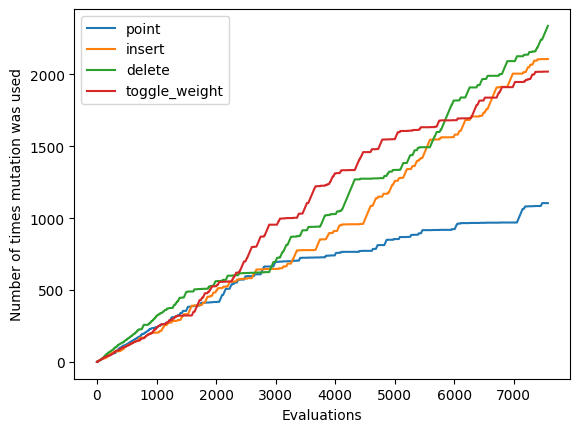

In [5]:
if __name__ == '__main__':
    import pandas as pd
    from brush import BrushClassifier
    
    import warnings
    warnings.filterwarnings("ignore")

    from pmlb import fetch_data

    # X, y = fetch_data('adult', return_X_y=True, local_cache_dir='./')

    data = pd.read_csv('../../docs/examples/datasets/d_analcatdata_aids.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'pop_size'  : 200,
        'max_gen'   : 40,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
        ('Modified', 'score'), ('Modified', 'best model'), 
        ('Modified', 'point mutation calls'),
        ('Modified', 'insert mutation calls'),
        ('Modified', 'delete mutation calls'),
        ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')
            kwargs['verbosity'] = (i==29) #verbosity only on last one

            est = BrushClassifier(**kwargs).fit(X,y)

            est_mab = BrushClassifierMod(**kwargs).fit(X,y)

            total_rewards = {arm_idx : sum([r for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            total_pulls   = {arm_idx : sum([1 for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            
            df.loc[f'run {i}'] = [est.score(X,y), est.best_estimator_.get_model(),
                                est_mab.score(X,y), est_mab.best_estimator_.get_model(), *total_pulls.values()]
        except Exception as e:
            print(e)

    display(df)
    display(df.describe())

    if True: # plot the cumulative history of pulls
        !pip install matplotlib > /dev/null
        import matplotlib.pyplot as plt

        # Plot for evaluations, not generations
        data = np.zeros( (len(est_mab.learner_.pull_history)+1, 4) )
        for i, (t, arm, r) in enumerate(est_mab.learner_.pull_history):
            data[i+1, :] = data[i]
            data[i+1, arm] += 1

        plt.plot(data, label=['point', 'insert', 'delete', 'toggle_weight'])
        plt.xlabel("Evaluations")
        plt.ylabel("Number of times mutation was used")

        for x in est_mab.learner_.reset_history:
            plt.axvline(x=x, color='k')

        plt.legend()